# CFIS footprint projection plot

Author: Mike Hudson

Adapted to ShapePipe: Martin Kilbinger

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.table

import cfis

%matplotlib inline

In [51]:
sp_home = '{}/astro/repositories/github/shapepipe'.format(os.environ['HOME'])
tiles_dir = '{}/aux/CFIS/tiles_202007'.format(sp_home)
patches = ['P1', 'P2', 'P3', 'P4']

In [52]:
plt.rcParams['figure.figsize'] = [10, 5]

In [53]:
class Footprint(object):
    
    def getxy(self, RA, Dec):
        # convert Dec first.
        y = np.floor((Dec+90.)*2+0.5)
        # Then use middle of the tile for the cos Dec term
        Decmid = y/2.-90.
        x = np.floor(RA*np.cos(Decmid/180.*np.pi)*2+0.5)
        return (x,y)

    def __init__(self, ra, dec):
        # input is a matched array of tile centres
        self.tilexy = []
        (x, y) = self.getxy(ra, dec)
        self.tilexy = y*1000+x

    def in_cfis(self, ra, dec):
        (x, y) = self.getxy(ra, dec)
        cell = y*1000+x
        return np.isin(cell, self.tilexy)
    
    def xy(self):
        return self.tilexy%1000, self.tilexy//1000
                
    def corners_from_xy(self, x, y):
        Decmid = y/2. - 90.
        Declo = Decmid - 0.25
        Dechi = Decmid + 0.25
        RAlo = (x-0.5)/np.cos(Decmid/180.*np.pi)/2.
        RAhi = (x+0.5)/np.cos(Decmid/180.*np.pi)/2.
        return ([RAlo, RAhi, RAhi, RAlo, RAlo],[Declo, Declo, Dechi, Dechi, Declo])


In [64]:
patch_name = {}
patch_footprint = {}
n_tiles = 0
for tag in patches:
    path = '{}/tiles_{}.txt'.format(tiles_dir, tag)
    patch_name[tag] = cfis.read_list(path)

    RA = []
    Dec = []
    for ID in patch_name[tag]:
        nix, niy = cfis.get_tile_number(ID)
        ra, dec = cfis.get_tile_coord_from_nixy(nix, niy)
        RA.append(ra.deg)
        Dec.append(dec.deg)
    RA = np.array(RA)
    Dec = np.array(Dec)

    patch_footprint[tag] = Footprint(RA, Dec)
    n_tiles_patch = len(patch_name[tag])
    print(tag, ':  ', n_tiles_patch, "tiles", end=', ')
    print(n_tiles_patch*0.25, "square degrees")
    n_tiles = n_tiles + n_tiles_patch

print('all : ', n_tiles, "tiles", end=', ')
print(n_tiles*0.25, "square degrees")


P1 :   3225 tiles, 806.25 square degrees
P2 :   1129 tiles, 282.25 square degrees
P3 :   995 tiles, 248.75 square degrees
P4 :   1430 tiles, 357.5 square degrees
all :  6779 tiles, 1694.75 square degrees


In [56]:
# http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html
def mwd_convert(RA,Dec,org=0.):
    x = np.remainder(RA+360.-org,360.) # shift RA values
    ind = x > 180.
    x[ind] -= 360.    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    return (np.radians(x),np.radians(Dec))

def mwd_grid(org=0.,projection='mollweide',title='Mollweide projection'):
    ''' 
        org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
        title is the title of the figure.
        projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection)
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)

In [57]:
# https://matplotlib.org/1.5.0/examples/text_labels_and_annotations/rainbow_text.html
from matplotlib import transforms

def rainbow_text(x, y, strings, colors, ax=None, **kw):
    """
    Take a list of ``strings`` and ``colors`` and place them next to each
    other, with text strings[i] being shown in colors[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.

    The text will get added to the ``ax`` axes, if provided, otherwise the
    currently active axes will be used.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    # horizontal version
    for s, c in zip(strings, colors):
        text = ax.text(x, y, " " + s + " ", color=c, transform=t, **kw)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, x=ex.width, units='dots')

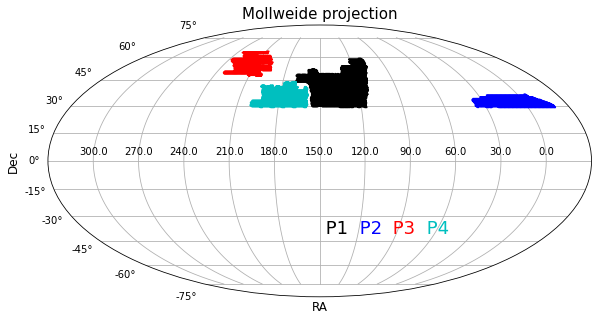

In [60]:
all_colours = {'P1':'k',
              'P2':'b',
              'P3':'r',
              'P4':'c',
              'P5':'m',
              'P6':'g'}
colours = {}
for patch in all_colours:
    if patch in patches:
        colours[patch] = all_colours[patch]
    
mwd_grid(org=150, title='Mollweide projection', projection='mollweide')
rainbow_text(0, -0.45*(np.pi/2), colours.keys(), colours.values(), size=18)

for tag in patches:
    (xx,yy) = patch_footprint[tag].xy()
    for (x,y) in zip(xx,yy):
        (ra,dec) = patch_footprint[tag].corners_from_xy(x, y)
        s = np.sin(np.radians(dec))
        (xx,yy) = mwd_convert(np.array(ra), np.array(dec), org=150)
        plt.plot(xx, yy, c=colours[tag])